# Task 1

The purpose of this task is to classify the demand for bikes on a specific day using predefined labels. The first stage of this will be to find appropriate values to use for the labels.

<a id='content'></a>
## Contents:
- [Preprocessing](#prep) - can skip running as data is reloaded at the start of the models
- [Models](#mods)

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn import tree

In [2]:
# Read in the data
train_data = pd.read_csv("./data/preprocessed_data/t1_train.csv")

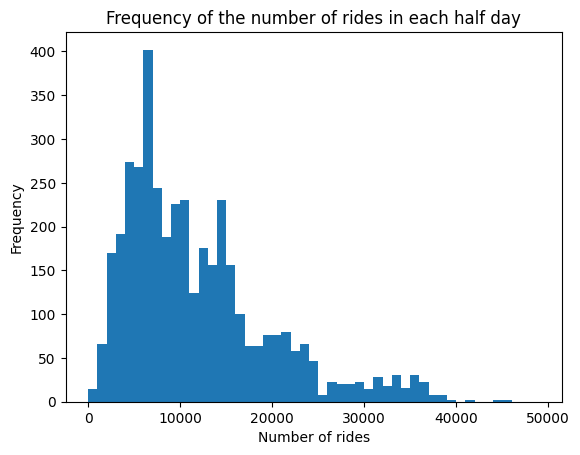

In [4]:
def dist_plot():
    plt.hist(train_data['rides_count'], bins=range(0,50000, 1000))

    plt.xlabel('Number of rides')
    plt.ylabel('Frequency')

dist_plot()
plt.title('Frequency of the number of rides in each half day')
plt.show()

It will be interesting to try different numbers of labels. For now, will create two versions. Three labels (low, medium and high) and five labels (very low, low, medium, high, very high). These will be implemented using numeric values for easier use later. These will be chosen by evenly dividing the data.

In [7]:
all_counts = list(train_data['rides_count'])
all_counts.sort()

# Thresholds for split into 3
label3_split = []
for i in range(1,3):
    label3 = all_counts[round(i*len(all_counts)/3)]
    label3_split.append(label3)

#Thresholds for split into 5
label5_split = []
for i in range(1,5):
    label5 = all_counts[round(i*len(all_counts)/5)]
    label5_split.append(label5)
    
print(label3_split, label5_split)

[6934, 13718] [5328, 7876, 12077, 17015]


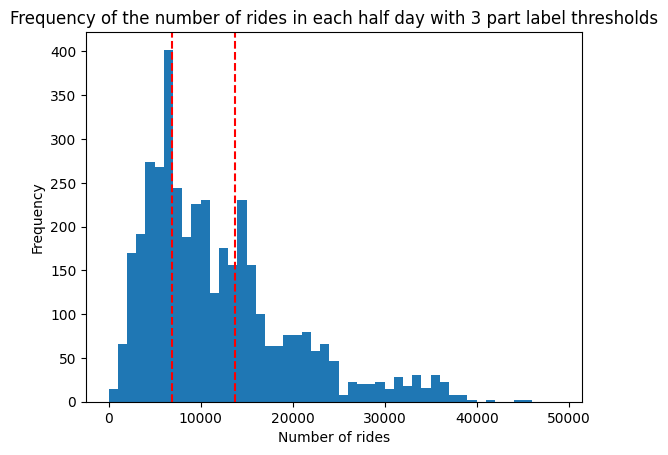

In [8]:
dist_plot()
for i in label3_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 3 part label thresholds')
plt.show()

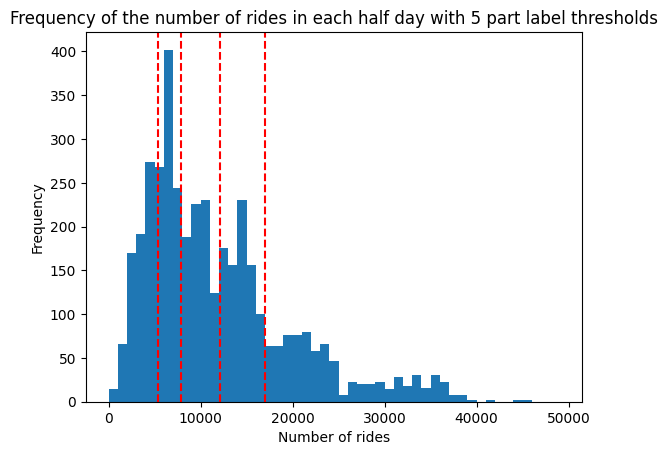

In [9]:
dist_plot()
for i in label5_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 5 part label thresholds')
plt.show()

<a id='mods'></a>
## Models
[Back to contents](#content)

First to read in the data, for if the earlier cells have not been run.

In [3]:
train_new = pd.read_csv("./data/preprocessed_data/t1_train.csv")
valid_new = pd.read_csv("./data/preprocessed_data/t1_valid.csv")
test_new = pd.read_csv("./data/preprocessed_data/t1_test.csv")

### Splitting data for models

In [4]:
def t1_datasplit(train, valid, test):
    train_1 = train.copy()
    valid_1 = valid.copy()
    test_1 = test.copy()
    
    train_target_a = train_new['label3']
    train_target_b = train_new['label5']
    valid_target_a = valid_new['label3']
    valid_target_b = valid_new['label5']
    test_target_a = test_new['label3']
    test_target_b = test_new['label5']
    
    train_1 = train_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    valid_1 = valid_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    test_1 = test_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    
    return train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b


### Baseline

Can now calculate a baseline for each of the 3 and 5 label set ups, using the proportion of the majority label in the test data.

In [5]:
train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train_new, valid_new, test_new)

from collections import Counter
test_count3 = Counter(test_target_a)
test_count5 = Counter(test_target_b)

total3 = 0
max3 = 0
total5 = 0
max5 = 0
for key, value in test_count3.items():
    total3 += value
    if value> max3:
        max3=value
for key, value in test_count5.items():
    total5 += value
    if value> max5:
        max5=value
        
print("3 label baseline: ", max3/total3)
print("5 label baseline: ", max5/total5)
print(test_count3)
print(test_count5)

3 label baseline:  1.0
5 label baseline:  1.0
Counter({3: 404})
Counter({5: 404})


### Define models

In [11]:
# KNN
def knn_t1(train, valid, test, n_range, label_set):
    train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train, valid, test)
    
    if label_set=='a':
        train_target = train_target_a
        valid_target = valid_target_a
        test_target = test_target_a
    else:
        train_target = train_target_b
        valid_target = valid_target_b
        test_target = test_target_b

    # create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', preprocessing.StandardScaler(), ['mean_temperature', 'total_precipitation']),
            ('encoder', preprocessing.OneHotEncoder(), ['am_pm', 'is_holiday', 'is_weekend', 'month']) ])

    best_n = 1
    best_weight = 'distance'
    best_acc = 0
    # choose the estimator and define a pipeline, using distance as weight
    for n in n_range:
        estimator = KNeighborsClassifier(n_neighbors=n, weights='distance')
        pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])
        pipeline.fit(train_1, train_target)
        val_predict = pipeline.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_n = n
            best_acc = val_acc
            
    for n in n_range:
        estimator = KNeighborsClassifier(n_neighbors=n, weights='uniform')
        pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])
        pipeline.fit(train_1, train_target)
        val_predict = pipeline.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_n = n
            best_weight = 'uniform'
            best_acc = val_acc        
    
    
    # run with best
    train_all = pd.concat([train_1, valid_1])
    train_target_all = pd.concat([train_target, valid_target])
    estimator = KNeighborsClassifier(n_neighbors=best_n, weights=best_weight)
    pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])
    pipeline.fit(train_all, train_target_all)
    test_pred = pipeline.predict(test_1)
    
    output = test.copy()
    output['pred']=test_pred
    output['actual']=test_target
    filename = 'results/t1_knn_'+label_set+'_n'+str(best_n)+'_'+best_weight+'.csv'
    output.to_csv(filename, index=False)
    
    return pipeline
    

In [7]:
# Decision tree
def dt_t1(train, valid, test, depth_range, label_set):
    train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train, valid, test)
    
    if label_set=='a':
        train_target = train_target_a
        valid_target = valid_target_a
        test_target = test_target_a
    else:
        train_target = train_target_b
        valid_target = valid_target_b
        test_target = test_target_b
    
    best_depth = 1
    best_acc = 0
    # choose the estimator and define a pipeline
    for n in depth_range:
        model = tree.DecisionTreeClassifier(max_depth=n)
        model.fit(train_1, train_target)
        val_predict = model.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_depth = n
            best_acc = val_acc
            
    train_all = pd.concat([train_1, valid_1])
    train_target_all = pd.concat([train_target, valid_target])
    model = tree.DecisionTreeClassifier(max_depth=best_depth)
    model.fit(train_all, train_target_all)
    test_pred = model.predict(test_1)
    
    output = test.copy()
    output['pred']=test_pred
    output['actual']=test_target
    filename = 'results/t1_dt_'+label_set+'_n'+str(best_depth)+'.csv'
    output.to_csv(filename, index=False)
    
    return model
    

In [12]:
# Random forest
def rf_t1(train, valid, test, depth_range, label_set):
    train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train, valid, test)
    
    if label_set=='a':
        train_target = train_target_a
        valid_target = valid_target_a
        test_target = test_target_a
    else:
        train_target = train_target_b
        valid_target = valid_target_b
        test_target = test_target_b

    best_depth = 1
    best_acc = 0
    for n in depth_range:
        model = RandomForestClassifier(max_depth=n, n_estimators=200, random_state=42)
        model.fit(train_1, train_target)
        val_predict = model.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_depth = n
            best_acc = val_acc
    
    # run with best
    train_all = pd.concat([train_1, valid_1])
    train_target_all = pd.concat([train_target, valid_target])
    model = RandomForestClassifier(n_estimators=best_depth, random_state=42)
    model.fit(train_all, train_target_all)
    test_pred = model.predict(test_1)
    
    output = test.copy()
    output['pred']=test_pred
    output['actual']=test_target
    filename = 'results/t1_rf_'+label_set+'_n'+str(best_depth)+'.csv'
    output.to_csv(filename, index=False)
    
    return model

### Run models
KNN:

In [13]:
random.seed(33)
knn_model_a = knn_t1(train_new, valid_new, test_new, range(1,201,1), 'a')
knn_model_b = knn_t1(train_new, valid_new, test_new, range(1,201,1), 'b')

Decision tree:

In [14]:
# Allowing very shallow trees to be specified
random.seed(33)
dt_model_1a = dt_t1(train_new, valid_new, test_new, range(1,26,1), 'a')
dt_model_1b = dt_t1(train_new, valid_new, test_new, range(1,26,1), 'b')
dt_1a_features = dt_model_1a.feature_importances_
dt_1b_features = dt_model_1b.feature_importances_

In [15]:
# Forcing deeper trees
random.seed(33)
dt_model_2a = dt_t1(train_new, valid_new, test_new, range(10,26,1), 'a')
dt_model_2b = dt_t1(train_new, valid_new, test_new, range(10,26,1), 'b')
dt_2a_features = dt_model_2a.feature_importances_
dt_2b_features = dt_model_2b.feature_importances_

Random forest:

In [16]:
# Allowing very shallow trees to be specified
rf_model_1a = rf_t1(train_new, valid_new, test_new, range(1,26,1), 'a')
rf_model_1b = rf_t1(train_new, valid_new, test_new, range(1,26,1), 'b')
rf_1a_features = rf_model_1a.feature_importances_
rf_1b_features = rf_model_1b.feature_importances_

In [17]:
# Forcing deeper trees
rf_model_2a = rf_t1(train_new, valid_new, test_new, range(10,26,1), 'a')
rf_model_2b = rf_t1(train_new, valid_new, test_new, range(10,26,1), 'b')
rf_2a_features = rf_model_2a.feature_importances_
rf_2b_features = rf_model_2b.feature_importances_

## Evaluation

In [27]:
a_eval_files = ['results/t1_knn_a_n101_uniform.csv', 'results/t1_dt_a_n5.csv', 'results/t1_dt_a_n11.csv','results/t1_rf_a_n3.csv', 'results/t1_rf_a_n11.csv']
b_eval_files = ['results/t1_knn_b_n194_uniform.csv', 'results/t1_dt_b_n1.csv', 'results/t1_dt_b_n11.csv','results/t1_rf_b_n2.csv','results/t1_rf_b_n10.csv']
models = ['KNN', 'Decision Tree 1', 'Decision Tree 2', 'Random Forest 1', 'Random Forest 2']

In [28]:
def t1_evaluate(filepath):
    res = pd.read_csv(filepath)
    actual_values = res['actual']
    predicted_values = res['pred']
    acc = accuracy_score(actual_values, predicted_values)
    prec = precision_score(actual_values, predicted_values, average='macro')
    f1 = f1_score(actual_values, predicted_values, average='macro')
    return acc, prec, f1  

def compare_results_t1(result_files, models, label_type):    
    results = []
    for i in range(len(result_files)):
        acc, prec, f1 = t1_evaluate(result_files[i])
        result = {
            'Model': models[i],
            'Accuracy': acc,
            'Precision': prec,
            'F1': f1
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    filename = 'results/evaluation_t1'+label_type+'.csv'
    results_df.to_csv(filename, index=False)
    print(results_df)

In [29]:
compare_results_t1(a_eval_files, models, 'a')
compare_results_t1(b_eval_files, models, 'b')

FileNotFoundError: [Errno 2] No such file or directory: 'results/t1_knn_a_n101_uniform.csv'

### Important features

In [21]:
feature_arrays = [dt_1a_features, dt_1b_features, dt_2a_features, dt_2b_features, rf_1a_features, rf_1b_features, rf_2a_features, rf_2b_features]
results = []
for i in feature_arrays:
    result = {
        'month': i[0],
        'am_pm': i[1],
        'weekday': i[2],
        'is_holiday': i[3],
        'is_weekend': i[4],
        'mean_temperature': i[5],
        'total_precipitation': i[6]
        }
    results.append(result)
results_df = pd.DataFrame(results)
results_df.index = ['dt1a', 'dt1b', 'dt2a', 'dt2b', 'rf1a', 'rf1b', 'rf2a', 'rf2b']
print(results_df)


         month     am_pm   weekday  is_holiday  is_weekend  mean_temperature  \
dt1a  0.000000  0.000000  0.000000    0.000000    0.000000          1.000000   
dt1b  0.000000  0.000000  0.000000    0.000000    0.000000          1.000000   
dt2a  0.000000  0.500207  0.400166    0.000000    0.000000          0.099627   
dt2b  0.000000  0.500207  0.000000    0.000000    0.000000          0.499793   
rf1a  0.000000  0.750311  0.001704    0.000000    0.000000          0.247699   
rf1b  0.000000  0.750311  0.001704    0.000000    0.000000          0.247699   
rf2a  0.026793  0.375659  0.055982    0.002542    0.039208          0.482799   
rf2b  0.026793  0.375659  0.055982    0.002542    0.039208          0.482799   

      total_precipitation  
dt1a             0.000000  
dt1b             0.000000  
dt2a             0.000000  
dt2b             0.000000  
rf1a             0.000286  
rf1b             0.000286  
rf2a             0.017017  
rf2b             0.017017  


### Confusion matrices

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [23]:
def cm_help(filepath, label_type):
    res = pd.read_csv(filepath)
    cnf_matrix = confusion_matrix(res['actual'], res['pred'])
    np.set_printoptions(precision=2)
    if label_type=='a':
        classes = ['Low', 'Medium', 'High']
    else:
        classes = ['Very low', 'Low', 'Medium', 'High', 'Very high']
    plot_confusion_matrix(cnf_matrix, classes=classes)

In [24]:
for i in range(len(models)):
    print(models[i]+":")
    cm_help(a_eval_files[i], 'a')
    cm_help(b_eval_files[i], 'b')

KNN:


FileNotFoundError: [Errno 2] No such file or directory: 'results/t1_knn_a_n101_uniform.csv'

### Percentiles

In [25]:
def split5(dataframe):
        all_counts = list(dataframe['rides_count'])
        all_counts.sort()

        #Thresholds for split into 5
        label5_split = []
        for i in range(1,5):
            label5 = all_counts[round(i*len(all_counts)/5)]
            label5_split.append(label5)
        
        output = np.select([dataframe['rides_count']<label5_split[0],
                                 dataframe['rides_count'].between(label5_split[0],label5_split[1]),
                                 dataframe['rides_count'].between(label5_split[1],label5_split[2]),
                                 dataframe['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)
        return output
    
def t1_percentile(filepath, target):
    res = pd.read_csv(filepath)
    actual_values = target
    predicted_values = res['pred']
    acc = accuracy_score(actual_values, predicted_values)
    prec = precision_score(actual_values, predicted_values, average='macro')
    f1 = f1_score(actual_values, predicted_values, average='macro')
    return acc, prec, f1     

def compare_percentile_t1(result_files, models, target):    
    results = []
    for i in range(len(result_files)):
        acc, prec, f1 = t1_percentile(result_files[i], target)
        result = {
            'Model': models[i],
            'Accuracy': acc,
            'Precision': prec,
            'F1': f1
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    filename = 'results/evaluation_t1_perc.csv'
    results_df.to_csv(filename, index=False)
    print(results_df)


In [26]:
test_perc_target = split5(test_new)
compare_percentile_t1(b_eval_files, models, test_perc_target)

FileNotFoundError: [Errno 2] No such file or directory: 'results/t1_knn_b_n194_uniform.csv'